In [9]:
import cv2
import mediapipe as mp
import numpy as np
import logging
import cProfile
from scipy.stats import circmean, circstd

cv2.setNumThreads(1)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose


In [10]:
from datetime import datetime
from math import sqrt

def calculate_angle(a, b, c):
    """
    b is the midpoint of a and c (e.g. left hip, left elbow and left shoulder)
    our case will be left-hip, left-knee and left-ankle
    """

    a = np.array(a)  # First
    b = np.array(b)  # Mid
    c = np.array(c)  # End

    radians = np.arctan2(c[1] - b[1], c[0] - b[0]) - np.arctan2(
        a[1] - b[1], a[0] - b[0]
    )
    angle = np.abs(radians * 180.0 / np.pi)
    
    if angle > 180.0:
        angle = 360 - angle

    return angle


import datetime


def to_timestamp(time_float):
    return datetime.datetime.fromtimestamp(time_float).strftime("%Y-%m-%d %H:%M:%S,%f")


def calculate_distance(p1, p2):
    return sqrt((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2)


def should_start_timer(
    hip_angle,
    hip_displacement,
    knee_displacement,
    ankle_displacement,
    threshold_angle=100.0,
    hip_thresh=3.0,
    knee_thresh=3.0,
    ankle_thresh=1.5,
):
    """
    Determine if the timer should start based on displacement conditions.
    """
    logging.info(f"Timer not started - Hip angle: {hip_angle:.2f} degrees")

    return hip_angle < threshold_angle and (
        hip_displacement > hip_thresh
        or knee_displacement > knee_thresh
        or ankle_displacement > ankle_thresh
    )


def get_landmark_coordinates(landmarks, frame_width, frame_height, side='LEFT'):
    """
    Fetches the coordinates of hip, knee, ankle, shoulder, wrist, and elbow landmarks,
    scaled by the frame dimensions.
    """
    if side == 'RIGHT':
        hip_idx = mp_pose.PoseLandmark.RIGHT_HIP.value
        knee_idx = mp_pose.PoseLandmark.RIGHT_KNEE.value
        ankle_idx = mp_pose.PoseLandmark.RIGHT_ANKLE.value
        shoulder_idx = mp_pose.PoseLandmark.RIGHT_SHOULDER.value
        wrist_idx = mp_pose.PoseLandmark.RIGHT_WRIST.value
        elbow_idx = mp_pose.PoseLandmark.RIGHT_ELBOW.value
    else:  # Default to LEFT
        hip_idx = mp_pose.PoseLandmark.LEFT_HIP.value
        knee_idx = mp_pose.PoseLandmark.LEFT_KNEE.value
        ankle_idx = mp_pose.PoseLandmark.LEFT_ANKLE.value
        shoulder_idx = mp_pose.PoseLandmark.LEFT_SHOULDER.value
        wrist_idx = mp_pose.PoseLandmark.LEFT_WRIST.value
        elbow_idx = mp_pose.PoseLandmark.LEFT_ELBOW.value

    hip = [
        landmarks[hip_idx].x * frame_width,
        landmarks[hip_idx].y * frame_height,
    ]
    knee = [
        landmarks[knee_idx].x * frame_width,
        landmarks[knee_idx].y * frame_height,
    ]
    ankle = [
        landmarks[ankle_idx].x * frame_width,
        landmarks[ankle_idx].y * frame_height,
    ]
    shoulder = [
        landmarks[shoulder_idx].x * frame_width,
        landmarks[shoulder_idx].y * frame_height,
    ]
    wrist = [
        landmarks[wrist_idx].x * frame_width,
        landmarks[wrist_idx].y * frame_height,
    ]
    elbow = [
        landmarks[elbow_idx].x * frame_width,
        landmarks[elbow_idx].y * frame_height,
    ]

    return hip, knee, ankle, shoulder, wrist, elbow


def determine_failure(elapsed_time, threshold_time=12, debug=True):
    """
    Determine if the user has failed based on the elapsed time.
    """
    # convert elapsed time to seconds
    logging.info(f"Elapsed time: {elapsed_time}")
    return "FAILED" if elapsed_time > threshold_time else "PASSED"


def summarise_results(counter, elapsed_time, rep_durations, violations, max_angles):
    """
    Logs a summary of video processing results including repetition counts and times,
    and uses determine_failure to log the pass/fail status based on elapsed time.
    """
    logging.info("==========================================================")
    logging.info("                     Video processing summary             ")
    logging.info("==========================================================")

    logging.info(f"Pass status: {determine_failure(elapsed_time, counter, True)}")
    logging.info(f"Total repetitions: {counter} completed in {elapsed_time:.2f} seconds")

    if violations:
        logging.info(f"Hand Violation count: {len(violations)}")
        for violation in violations:
            logging.info(f"Violation at {violation[1]:.2f}s: {violation[2]}")

    if rep_durations:
        for idx, reps in enumerate(rep_durations, 1):
            logging.info(f"Duration of Rep {idx}: {reps:.2f} seconds")
        logging.info(f"Maximum duration per repetition: {max(rep_durations):.2f} seconds")
        average_duration = sum(rep_durations) / len(rep_durations)
        logging.info(f"Average duration per repetition: {average_duration:.2f} seconds")

    if max_angles:
        logging.info(f"Maximum angle per repetition: {max(max_angles):.2f} degrees")
        average_angle = sum(max_angles) / len(max_angles)
        logging.info(f"Average angle per repetition: {average_angle:.2f} degrees")


def display_knee_and_hip_angle(image, knee_angle, knee, hip_angle, hip, x_displacement=60):
    """
    Display the knee angle on the screen. 60px to the right of the knee
    """
    cv2.putText(
        image,
        f"{knee_angle} deg",
        (int(knee[0] + x_displacement), int(knee[1])),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (255, 255, 255),
        2,
        cv2.LINE_AA,
    )
    cv2.putText(
        image,
        f"{hip_angle} deg",
        (int(hip[0] + x_displacement), int(hip[1])),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (255, 255, 255),
        2,
        cv2.LINE_AA,
    )


def draw_joint_displacement(prev_point, curr_point, image):
    prev_x, prev_y = map(int, prev_point)
    curr_x, curr_y = map(int, curr_point)
    cv2.circle(image, (curr_x, curr_y), 10, (0, 0, 255), -1)
    cv2.line(image, (prev_x, prev_y), (curr_x, curr_y), (0, 255, 0), 2)


def display_x_and_y_from_point(point):
    """
    Returns a string representation of the x and y coordinates of the point.
    """
    return f"(x:{point[0]:.2f}, y:{point[1]:.2f})"


def calculate_and_draw_joint_displacement(
    prev_frame, prev_points, curr_points, image, joint_displacement_history, real_time
):
    logging.info(
        "========================= Optical flow results ========================="
    )
    joint_names = ("HIP", "KNEE", "ANKLE")  # Names of the joints
    prev_hip, prev_knee, prev_ankle = prev_points
    hip, knee, ankle = curr_points
    if prev_frame is not None:
        for prev_point, curr_point, _, joint_name in zip(
            [prev_hip, prev_knee, prev_ankle],
            [hip, knee, ankle],
            [(0, 0, 255)] * 3,
            joint_names,
        ):
            draw_joint_displacement((prev_point), curr_point, image)
            displacement = calculate_distance(prev_point, curr_point)
            logging.info(
                f"{joint_name} Displacement: {displacement:.2f} px (from {display_x_and_y_from_point(prev_point)} to {display_x_and_y_from_point(curr_point)})"
            )
            joint_displacement_history[joint_name].append((real_time, displacement))
    return joint_displacement_history


def calculate_and_store_velocities(
    hip_displacement,
    knee_displacement,
    ankle_displacement,
    frame_time,
    joint_displacement,
    joint_velocity_history,
):
    hip_velocity = hip_displacement / frame_time
    knee_velocity = knee_displacement / frame_time
    ankle_velocity = ankle_displacement / frame_time
    logging.info(
        f"Hip Velocity: {hip_velocity:.2f} px/s, Knee Velocity: {knee_velocity:.2f} px/s, Ankle Velocity: {ankle_velocity:.2f} px/s"
    )
    joint_velocity_history["HIP"].append(hip_velocity)
    joint_velocity_history["KNEE"].append(knee_velocity)
    joint_velocity_history["ANKLE"].append(ankle_velocity)

    return joint_velocity_history


def display_information(image, counter, stage, max_angle):
    """
    Display the number of repetitions on the screen.
    """
    # Setup status box
    cv2.rectangle(image, (0, 0), (550, 100), (245, 117, 16), -1)

    # Rep data
    cv2.putText(
        image,
        "REPS",
        (15, 12),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (0, 0, 0),
        1,
        cv2.LINE_AA,
    )
    cv2.putText(
        image,
        str(counter),
        (10, 60),
        cv2.FONT_HERSHEY_SIMPLEX,
        2,
        (255, 255, 255),
        2,
        cv2.LINE_AA,
    )

    # Stage data
    cv2.putText(
        image,
        "STAGE",
        (65, 12),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (0, 0, 0),
        1,
        cv2.LINE_AA,
    )
    cv2.putText(
        image,
        stage,
        (60, 60),
        cv2.FONT_HERSHEY_SIMPLEX,
        2,
        (255, 255, 255),
        2,
        cv2.LINE_AA,
    )
    # display max_angle per rep
    # display_max_angle(image, max_angle)

    cv2.putText(
        image,
        "MAX ANGLE",
        (300, 12),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (0, 0, 0),
        1,
        cv2.LINE_AA,
    )
    cv2.putText(
        image,
        f"{max_angle:.2f}",
        (250, 60),
        cv2.FONT_HERSHEY_SIMPLEX,
        2,
        (255, 255, 255),
        2,
    )


def display_timer(image, elapsed_time):
    """
    Display the elapsed time on the screen.
    """
    cv2.putText(
        image,
        f"Time: {elapsed_time:.2f} s",
        (800, 60),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (255, 255, 255),
        2,
        cv2.LINE_AA,
    )


def draw_landmarks_and_connections(image, results):
    """
    Draw the landmarks and connections on the image.
    """
    mp_drawing.draw_landmarks(
        image,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
        mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2),
    )


def get_real_time_from_frames(frame_counter, fps):
    return frame_counter / fps

def check_completion(counter,stage):
    # Check if 5 reps are completed
    return counter >= 5 and stage == "down"

class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    # define print method
    
    def __str__(self):
        return f'({self.x}, {self.y})'
    
def get_keypoints(landmarks):
        # Convert NormalizedLandmark to Point
        left_hip = Point(
            landmarks[mp_pose.PoseLandmark.LEFT_HIP].x,
            landmarks[mp_pose.PoseLandmark.LEFT_HIP].y,
        )
        right_hip = Point(
            landmarks[mp_pose.PoseLandmark.RIGHT_HIP].x,
            landmarks[mp_pose.PoseLandmark.RIGHT_HIP].y,
        )
        nose = Point(
            landmarks[mp_pose.PoseLandmark.NOSE].x,
            landmarks[mp_pose.PoseLandmark.NOSE].y,
        )
        left_ankle = Point(
            landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].x,
            landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].y,
        )
        right_ankle = Point(
            landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE].x,
            landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE].y,
        )
        left_toe = Point(
            landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].x,
            landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].y,
        )
        right_toe = Point(
            landmarks[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX].x,
            landmarks[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX].y,
        )
        left_shoulder = Point(
            landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].x,
            landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].y,
        )
        right_shoulder = Point(
            landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].x,
            landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].y,
        )
        left_knee = Point(
            landmarks[mp_pose.PoseLandmark.LEFT_KNEE].x,
            landmarks[mp_pose.PoseLandmark.LEFT_KNEE].y,
        )
        right_knee = Point(
            landmarks[mp_pose.PoseLandmark.RIGHT_KNEE].x,
            landmarks[mp_pose.PoseLandmark.RIGHT_KNEE].y,
        )
        keypoints = {
            "NOSE": nose,
            "LEFT_SHOULDER": left_shoulder,
            "RIGHT_SHOULDER": right_shoulder,
            "LEFT_HIP": left_hip,
            "RIGHT_HIP": right_hip,
            "LEFT_KNEE": left_knee,
            "RIGHT_KNEE": right_knee,
            "LEFT_ANKLE": left_ankle,
            "RIGHT_ANKLE": right_ankle,
            "LEFT_TOE": left_toe,
            "RIGHT_TOE": right_toe,
            
        }
        return keypoints

In [11]:
def process_sit_stand(video_path, display):
    # Initialize variables for counter logic
    counter = 0
    stage = None
    confirm_frames = 5
    stage_counter = 0
    max_angle_per_rep = 0
    last_angle = 0
    up_stage_threshold_angle = 135
    down_stage_threshold_angle = 105
    elbow_angle_threshold = 50

    # Initialize variables for optical flow
    prev_frame = None
    prev_hip = None
    prev_knee = None
    prev_ankle = None

    # for optical flow postprocessing
    joint_history = {
        "HIP": [],
        "KNEE": [],
        "ANKLE": [],
    }

    joint_displacement_history = {
        "HIP": [],
        "KNEE": [],
        "ANKLE": [],
    }
    joint_velocity_history = {
        "HIP": [],
        "KNEE": [],
        "ANKLE": [],
    }
    timer_started = False
    max_angles = []
    frames_after_start = 0
    frame_rate = None
    elapsed_time = 0
    finished = False
    rep_durations = []  # List to store the duration of each repetition
    rep_start_time = -1  # Uninitialized state
    last_rep_end_time = 0  # To store the end time of the last repetition
    violations = []

    previous_gray = None
    previous_keypoints = None
    keypoints_over_time = []

    try:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise ValueError("Error: Cannot open video file.")
        frame_rate = cap.get(cv2.CAP_PROP_FPS)
    except ValueError as e:
        logging.error(e)
        return
    with mp_pose.Pose(
        min_detection_confidence=0.5, min_tracking_confidence=0.5
    ) as pose:
        while cap.isOpened() and not finished:
            ret, frame = cap.read()
            if not ret:
                logging.warning("No frame captured from the video source.")
                break

            frame_height, frame_width, _ = frame.shape

            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False
            results = pose.process(image)
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            current_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            if prev_frame is not None and timer_started:
                elapsed_time = get_real_time_from_frames(frames_after_start, frame_rate)
                frames_after_start += 1

            # Process the frame
            if results.pose_landmarks:
                landmarks = results.pose_landmarks.landmark

                # Extract coordinates multiplied by frame dimensions for optical flow and angle calculation
                hip, knee, ankle, shoulder, wrist, elbow = get_landmark_coordinates(
                    landmarks, frame_width, frame_height, side="LEFT"
                )

                keypoints = get_keypoints(landmarks)
                keypoint_array = np.array(
                    [
                        [kp.x * frame.shape[1], kp.y * frame.shape[0]]
                        for kp in keypoints.values()
                    ],
                    dtype=np.float32,
                ).reshape(-1, 1, 2)
                # Calculate motion vectors using optical flow
                if previous_gray is not None and previous_keypoints is not None:
                    p1, st, err = cv2.calcOpticalFlowPyrLK(
                        previous_gray, current_gray, previous_keypoints, None
                    )

                    current_frame_keypoints = {}

                    for i, (new, old) in enumerate(zip(p1, previous_keypoints)):
                        new_x, new_y = new.ravel()
                        old_x, old_y = old.ravel()

                        motion_magnitude = np.sqrt(
                            (new_x - old_x) ** 2 + (new_y - old_y) ** 2
                        )
                        motion_angle = np.arctan2(new_y - old_y, new_x - old_x)

                        key = list(keypoints.keys())[i]
                        current_frame_keypoints[key] = (motion_magnitude, motion_angle)
                        logging.info(
                            f"{key} - Magnitude: {motion_magnitude}, Angle: {motion_angle} radians"
                        )

                        # Optionally, visualize the motion (debugging)
                        if display:
                            cv2.arrowedLine(
                                frame,
                                (int(old_x), int(old_y)),
                                (int(new_x), int(new_y)),
                                (0, 255, 0),
                                2,
                                tipLength=0.5,
                            )
                    keypoints_over_time.append(current_frame_keypoints)
                    previous_keypoints = p1
                else:
                    previous_keypoints = keypoint_array

                previous_gray = current_gray

                joint_history["HIP"].append(hip)
                joint_history["KNEE"].append(knee)
                joint_history["ANKLE"].append(ankle)

                # Calculate angles
                angle = calculate_angle(hip, knee, ankle)
                hip_angle = calculate_angle(shoulder, hip, knee)
                display_knee_and_hip_angle(image, angle, knee, hip_angle, hip)

                if (
                    prev_hip is not None
                    and prev_knee is not None
                    and prev_ankle is not None
                ):
                    # Calculate displacements
                    joint_displacement_history = calculate_and_draw_joint_displacement(
                        prev_frame,
                        [prev_hip, prev_knee, prev_ankle],
                        [hip, knee, ankle],
                        image,
                        joint_displacement_history,
                        elapsed_time,
                    )

                    # Get most recent displacement from history
                    hip_displacement = joint_displacement_history["HIP"][-1][1]
                    knee_displacement = joint_displacement_history["KNEE"][-1][1]
                    ankle_displacement = joint_displacement_history["ANKLE"][-1][1]

                    # Determine if the action timer should start
                    if not timer_started and should_start_timer(
                        hip_angle,
                        hip_displacement,
                        knee_displacement,
                        ankle_displacement,
                    ):
                        timer_started = True
                        logging.info(f"Timer started at {elapsed_time:.2f} seconds.")

                prev_frame = frame.copy()
                prev_hip, prev_knee, prev_ankle = hip, knee, ankle

                # Counting logic
                if stage is None:
                    stage = "up" if angle > up_stage_threshold_angle else "down"

                if (
                    timer_started
                    and stage == "down"
                    and angle < up_stage_threshold_angle
                ):
                    if rep_start_time == -1:
                        rep_start_time = (
                            elapsed_time  # Only set once per rep to avoid resetting
                        )

                # Hand angle violation detection
                if stage_counter >= confirm_frames:
                    hand_angle = calculate_angle(shoulder, elbow, wrist)
                    if hand_angle > elbow_angle_threshold:
                        violations.append(
                            (
                                "HAND",
                                elapsed_time,
                                f"Hand angle violation: {hand_angle:.2f} degrees",
                            )
                        )
                        logging.info(
                            f"Hand angle violation detected: {hand_angle:.2f} degrees."
                        )

                # Transition from DOWN to UP
                if stage == "down" and angle > up_stage_threshold_angle:
                    stage_counter += 1
                    if stage_counter >= confirm_frames:
                        stage = "up"
                        stage_counter = 0
                        counter += 1
                        logging.info(f"Transitioned to up. Total reps: {counter}")
                        max_angles.append(max_angle_per_rep)
                        max_angle_per_rep = 0  # Reset max angle for the new repetition
                        rep_duration = elapsed_time - last_rep_end_time
                        rep_durations.append(
                            rep_duration
                        )  # Store the duration of the rep
                        last_rep_end_time = (
                            elapsed_time  # Set end time for the next rep
                        )
                        logging.info(
                            f"Repetition {counter} completed in {rep_duration:.2f} seconds."
                        )

                # Transition from UP to DOWN
                elif stage == "up" and angle < down_stage_threshold_angle:
                    stage_counter += 1
                    if stage_counter >= confirm_frames:
                        stage = "down"
                        stage_counter = 0
                        logging.info("Transitioned to down.")

                # Check if 5 reps are completed
                if check_completion(counter, stage):
                    logging.info(
                        f"5 repetitions completed in {elapsed_time:.2f} seconds."
                    )
                    finished = True

                # Update max angle
                if angle > max_angle_per_rep:
                    max_angle_per_rep = angle
                last_angle = angle

                if display:
                    display_information(image, counter, stage, max_angle_per_rep)
                    draw_landmarks_and_connections(image, results)
                    display_timer(image, elapsed_time)
                    cv2.imshow("5 Rep Sit Stand Test", image)

                if cv2.waitKey(10) & 0xFF == ord("q"):
                    break
            else:
                if display:
                    cv2.imshow("5 Rep Sit Stand Test", image)
                if cv2.waitKey(10) & 0xFF == ord("q"):
                    break

        cap.release()
        cv2.destroyAllWindows()
        if keypoints_over_time:
            keypoint_mean_magnitudes = {
                keypoint: sum(frame[keypoint][0] for frame in keypoints_over_time)
                / len(keypoints_over_time)
                for keypoint in keypoints_over_time[0]
            }
            keypoint_std_devs = {
                keypoint: np.std([frame[keypoint][0] for frame in keypoints_over_time])
                for keypoint in keypoints_over_time[0]
            }
            keypoint_circular_mean = {
                keypoint: circmean(
                    [frame[keypoint][1] for frame in keypoints_over_time],
                    high=np.pi,
                    low=-np.pi,
                )
                for keypoint in keypoints_over_time[0]
            }
            keypoint_circular_std = {
                keypoint: circstd(
                    [frame[keypoint][1] for frame in keypoints_over_time],
                    high=np.pi,
                    low=-np.pi,
                )
                for keypoint in keypoints_over_time[0]
            }

        else:
            keypoint_std_devs = -1
            keypoint_mean_magnitudes = -1
            logging.info("No keypoints detected")
        summarise_results(counter, elapsed_time, rep_durations, violations, max_angles)

        return (
            "5 Sit Stand",
            determine_failure(elapsed_time, counter, False),
            counter,
            elapsed_time,
            rep_durations,
            violations,
            max_angles,
            keypoint_mean_magnitudes,
            keypoint_std_devs,
            keypoint_circular_mean,
            keypoint_circular_std,
        )


# video_path = "/Users/brennanlee/Desktop/opencv-healthcare/test/CST_self2.mp4"


In [12]:
video_path1 = "/Users/brennanlee/Desktop/opencv-healthcare/test/CST_low.mp4"
video_path2 = "/Users/brennanlee/Desktop/opencv-healthcare/test/High_Frailty/5ST_High.mp4"

import pandas as pd

df = pd.DataFrame(
    columns=[
        "test",
        "status",
        "reps",
        "time",
        "rep_durations",
        "violations",
        "max_angles",
        "keypoint_mean_magnitudes",
        "keypoint_std_devs",
        "keypoint_circular_mean",
        "keypoint_circular_std",
    ]
)
for video_path in [video_path1, video_path2]:
    (
        test,
        status,
        reps,
        time,
        rep_durations,
        violations,
        max_angles,
        keypoint_mean_magnitudes,
        keypoint_std_devs,
        keypoint_circular_mean,
        keypoint_circular_std,
    ) = process_sit_stand(video_path, False)
    
    # place the results in a data frame, note the double brackets to pass each row as a list of lists
    df = pd.concat(
        [
            df,
            pd.DataFrame(
                [[
                    test,
                    status,
                    reps,
                    time,
                    rep_durations,
                    violations,
                    max_angles,
                    keypoint_mean_magnitudes,
                    keypoint_std_devs,
                    keypoint_circular_mean,
                    keypoint_circular_std,
                ]],
                columns=[
                    "test",
                    "status",
                    "reps",
                    "time",
                    "rep_durations",
                    "violations",
                    "max_angles",
                    "keypoint_mean_magnitudes",
                    "keypoint_std_devs",
                    "keypoint_circular_mean",
                    "keypoint_circular_std",
                    
                ],
            ),
        ]
    )

# keypoint_mean_magnitudes, keypoint_std_devs, keypoint_circular_mean, keypoint_circular_std are dictionaries of keypoints as key and std as values, flatten them into a single column for each keypoint
for keypoint in keypoint_mean_magnitudes:
    df[keypoint + "_mean_magnitude"] = df["keypoint_mean_magnitudes"].apply(
        lambda x: x[keypoint]
    )
    df[keypoint + "_std_dev"] = df["keypoint_std_devs"].apply(lambda x: x[keypoint])
    df[keypoint + "_circular_mean"] = df["keypoint_circular_mean"].apply(
        lambda x: x[keypoint]
    )
    df[keypoint + "_circular_std"] = df["keypoint_circular_std"].apply(
        lambda x: x[keypoint]
    )
    
df.drop(
    columns=[
        "keypoint_mean_magnitudes",
        "keypoint_std_devs",
        "keypoint_circular_mean",
        "keypoint_circular_std",
    ],
    inplace=True,
)



2024-10-03 03:47:33,398 - INFO - NOSE - Magnitude: 2.538751704194536, Angle: -2.9626853466033936 radians
2024-10-03 03:47:33,399 - INFO - LEFT_SHOULDER - Magnitude: 3.7503212875577625, Angle: 3.006690263748169 radians
2024-10-03 03:47:33,399 - INFO - RIGHT_SHOULDER - Magnitude: 3.2347779529761804, Angle: -3.0291643142700195 radians
2024-10-03 03:47:33,400 - INFO - LEFT_HIP - Magnitude: 0.9087921283538216, Angle: -0.12253899872303009 radians
2024-10-03 03:47:33,400 - INFO - RIGHT_HIP - Magnitude: 2.1316334405015662, Angle: -0.11916624009609222 radians
2024-10-03 03:47:33,401 - INFO - LEFT_KNEE - Magnitude: 2.7275236986712996, Angle: -1.2386963367462158 radians
2024-10-03 03:47:33,402 - INFO - RIGHT_KNEE - Magnitude: 2.005520589572354, Angle: -1.3610038757324219 radians
2024-10-03 03:47:33,402 - INFO - LEFT_ANKLE - Magnitude: 4.081236025817717, Angle: -2.067582845687866 radians
2024-10-03 03:47:33,403 - INFO - RIGHT_ANKLE - Magnitude: 0.6068970231127301, Angle: -3.082423448562622 radians

In [14]:
df.to_csv("CST_final_results.csv", index=False)
# Synthetic Data
# test, status, reps, time, rep_durations, violations, max_angles, keypoint_mean_magnitudes, keypoint_std_devs, keypoint_circular_mean, keypoint_circular_std
# print(test)
# print(status)
# print(reps)
# print(time)
# print(rep_durations)
# print(violations)
# print(max_angles)
# print(keypoint_mean_magnitudes)
# print(keypoint_std_devs)
# print(keypoint_circular_mean)
# print(keypoint_circular_std)


# keypoint_std_devs is a dictionary of the standard deviation of the motion magnitudes for each keypoint
# plot the standard deviation of the motion magnitudes for each keypoint
# import matplotlib.pyplot as plt


# plt.figure(figsize=(20, 5))
# plt.bar(keypoint_std_devs.keys(), keypoint_std_devs.values())
# plt.title("Standard Deviation of Motion Magnitudes for Each Keypoint")
# plt.ylabel("Standard Deviation")
# plt.xlabel("Keypoint")
# plt.show()






In [ ]:
data = {
    "elapsed_time": [time],
    "rep_durations": [rep_durations],
    "max_angles": [max_angles],
    "keypoint_mean_magnitudes": [keypoint_mean_magnitudes],
    "keypoint_std_devs": [keypoint_std_devs],
    "keypoint_circular_mean": [keypoint_circular_mean],
    "keypoint_circular_std": [keypoint_circular_std],
}
import pandas as pd
df = pd.DataFrame(data)
print(df)

def determine_failure(elapsed_time, counter, debug=False, threshold_time=12.0):
    return "PASSED" if counter == 5 and elapsed_time < threshold_time else "FAILED"

def generate_synthetic_sample():
    # Randomly determine the number of repetitions (e.g., between 3 and 5)
    # reps = np.random.randint(3, 6)
    reps = 5
    
    # Generate repetition durations
    mean_duration = 3.0
    std_duration = 0.5
    rep_durations = np.random.normal(mean_duration, std_duration, reps)
    rep_durations = np.clip(rep_durations, 1.0, 5.0)
    
    # Generate max angles
    mean_angle = 170.0
    std_angle = 5.0
    max_angles = np.random.normal(mean_angle, std_angle, reps)
    max_angles = np.clip(max_angles, 150.0, 180.0)
    
    # Calculate total time
    time = np.sum(rep_durations)
    
    # Generate keypoint metrics
    keypoints = ['NOSE', 'LEFT_SHOULDER', 'RIGHT_SHOULDER', 'LEFT_HIP', 'RIGHT_HIP', 'LEFT_KNEE', 'RIGHT_KNEE', 'LEFT_ANKLE', 'RIGHT_ANKLE', 'LEFT_TOE', 'RIGHT_TOE']
    keypoint_mean_magnitudes = {}
    keypoint_std_devs = {}
    keypoint_circular_mean = {}
    keypoint_circular_std = {}
    
    for kp in keypoints:
        # Mean magnitudes
        mean_magnitude = np.random.uniform(1.0, 20.0)
        std_magnitude = np.random.uniform(0.5, 5.0)
        keypoint_mean_magnitudes[kp] = mean_magnitude
        keypoint_std_devs[kp] = std_magnitude
        
        # Circular metrics (angles in radians)
        mean_angle_rad = np.random.uniform(-np.pi, np.pi)
        std_angle_rad = np.random.uniform(0.1, 1.0)
        keypoint_circular_mean[kp] = mean_angle_rad
        keypoint_circular_std[kp] = std_angle_rad
    
    # Determine failure status
    status = determine_failure(time, reps)
    
    return {
        'reps': reps,
        'time': time,
        'rep_durations': rep_durations.tolist(),
        'violations': [],  # Assuming no violations
        'max_angles': max_angles.tolist(),
        'keypoint_mean_magnitudes': keypoint_mean_magnitudes,
        'keypoint_std_devs': keypoint_std_devs,
        'keypoint_circular_mean': keypoint_circular_mean,
        'keypoint_circular_std': keypoint_circular_std,
        'status': status
    }

# Generate multiple synthetic samples
synthetic_dataset = [generate_synthetic_sample() for _ in range(100)]
synthetic_df = pd.DataFrame(synthetic_dataset).head()
# Now, you can work with synthetic_df, keeping in mind that some columns contain variable-length lists

import matplotlib.pyplot as plt
import seaborn as sns

# Plot Elapsed Time
plt.figure(figsize=(10, 6))
sns.histplot(synthetic_df['time'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Total Times')
plt.xlabel('Total Time (seconds)')
plt.ylabel('Frequency')
plt.show()


# Plot rep durations
# Flatten the list of repetition durations
all_rep_durations = [duration for sublist in synthetic_df['rep_durations'] for duration in sublist]

# Histogram of repetition durations
plt.figure(figsize=(10, 6))
sns.histplot(all_rep_durations, bins=20, kde=True, color='salmon')
plt.title('Distribution of Repetition Durations')
plt.xlabel('Repetition Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

# Flatten the list of maximum angles
all_max_angles = [angle for sublist in synthetic_df['max_angles'] for angle in sublist]

# Histogram of maximum angles
plt.figure(figsize=(10, 6))
sns.histplot(all_max_angles, bins=20, kde=True, color='lightgreen')
plt.title('Distribution of Maximum Angles')
plt.xlabel('Maximum Angle (degrees)')
plt.ylabel('Frequency')
plt.show()

# Create a DataFrame from the keypoint mean magnitudes
keypoint_magnitudes_df = pd.DataFrame(synthetic_df['keypoint_mean_magnitudes'].tolist())

# Boxplot of keypoint mean magnitudes
plt.figure(figsize=(12, 6))
sns.boxplot(data=keypoint_magnitudes_df)
plt.title('Keypoint Mean Magnitudes')
plt.xlabel('Keypoints')
plt.ylabel('Mean Magnitude')
plt.xticks(rotation=45)
plt.show()


# Create a DataFrame from the keypoint standard deviations
keypoint_std_devs_df = pd.DataFrame(synthetic_df['keypoint_std_devs'].tolist())

# Boxplot of keypoint standard deviations
plt.figure(figsize=(12, 6))
sns.boxplot(data=keypoint_std_devs_df)
plt.title('Keypoint Standard Deviations')
plt.xlabel('Keypoints')
plt.ylabel('Standard Deviation')
plt.xticks(rotation=45)
plt.show()

# Create a DataFrame from the keypoint circular means
keypoint_circular_mean_df = pd.DataFrame(synthetic_df['keypoint_circular_mean'].tolist())

# Convert radians to degrees for better interpretability
keypoint_circular_mean_degrees = keypoint_circular_mean_df * (180 / np.pi)

# Histograms of keypoint circular means
for kp in keypoint_circular_mean_degrees.columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(keypoint_circular_mean_degrees[kp], bins=20, kde=True)
    plt.title(f'Distribution of Circular Mean for {kp}')
    plt.xlabel('Angle (degrees)')
    plt.ylabel('Frequency')
    plt.show()
    

# Count plot of status
# plt.figure(figsize=(6, 4))
# sns.countplot(x='status', data=synthetic_df, palette='pastel')
# plt.title('Status Counts')
# plt.xlabel('Status')
# plt.ylabel('Count')
# plt.show()

# print out the pass and fails
print(synthetic_df['status'].value_counts())




In [32]:
import cProfile
# Profile the first version (e.g., the Python version)
cProfile.run('process_sit_stand(video_path, False)', 'sit_stand_python.prof')

# Import the module containing the second version (e.g., the Cython version)
import sit_stand_overall


import pstats
p = pstats.Stats('sit_stand_python.prof')
print(p.strip_dirs().sort_stats(-1).print_stats())


2024-09-18 01:19:43,490 - INFO - NOSE - Magnitude: 6.801382110650426, Angle: -0.16126419603824615 radians
2024-09-18 01:19:43,491 - INFO - LEFT_SHOULDER - Magnitude: 8.979321776365628, Angle: -0.27051642537117004 radians
2024-09-18 01:19:43,492 - INFO - RIGHT_SHOULDER - Magnitude: 3.165732488144172, Angle: 0.033071137964725494 radians
2024-09-18 01:19:43,493 - INFO - LEFT_HIP - Magnitude: 0.5434159145927208, Angle: -0.19417956471443176 radians
2024-09-18 01:19:43,494 - INFO - RIGHT_HIP - Magnitude: 1.008444900003831, Angle: -0.3384599983692169 radians
2024-09-18 01:19:43,495 - INFO - LEFT_KNEE - Magnitude: 1.755157640501684, Angle: -1.7306225299835205 radians
2024-09-18 01:19:43,495 - INFO - RIGHT_KNEE - Magnitude: 1.8065783515713796, Angle: -2.6906371116638184 radians
2024-09-18 01:19:43,496 - INFO - LEFT_ANKLE - Magnitude: 1.7290755620380653, Angle: -0.5092859268188477 radians
2024-09-18 01:19:43,497 - INFO - RIGHT_ANKLE - Magnitude: 0.3423100474690082, Angle: -0.7630171179771423 rad

Wed Sep 18 01:20:28 2024    sit_stand_python.prof

         3165570 function calls (3129225 primitive calls) in 45.367 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.878    0.878   45.367   45.367 1323827476.py:1(process_sit_stand)
      523    0.006    0.000    0.006    0.000 1323827476.py:94(<listcomp>)
        2    0.000    0.000    0.003    0.001 1578719531.py:106(determine_failure)
        1    0.000    0.000    0.019    0.019 1578719531.py:115(summarise_results)
      523    0.011    0.000    1.000    0.002 1578719531.py:145(display_knee_and_hip_angle)
     1566    0.011    0.000    0.165    0.000 1578719531.py:171(draw_joint_displacement)
     3132    0.006    0.000    0.006    0.000 1578719531.py:178(display_x_and_y_from_point)
      522    0.023    0.000    2.082    0.004 1578719531.py:185(calculate_and_draw_joint_displacement)
     1566    0.005    0.000    0.007    0.000 1578719531.py:32(calculate

In [4]:
import cProfile
import sit_stand_overall
import pstats
# Profile the second version
cProfile.run('sit_stand_overall.process_sit_stand(video_path, False)', 'sit_stand_cython.prof')
p = pstats.Stats('sit_stand_cython.prof')
print(p.strip_dirs().sort_stats(-1).print_stats())


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
2024-09-24 23:17:25,460 - INFO - ============================ Processing frame 1.0 ============================
2024-09-24 23:17:25,818 - INFO - ============================ Processing frame 2.0 ============================
2024-09-24 23:17:25,860 - INFO - --- Displacement Information ---
2024-09-24 23:17:25,863 - INFO - HIP Displacement: 17.01 px (from (x:626.44, y:1087.90) to (x:611.29, y:1080.18))
2024-09-24 23:17:25,864 - INFO - KNEE Displacement: 0.39 px (from (x:220.90, y:1187.20) to (x:220.89, y:1187.59))
2024-09-24 23:17:25,864 - INFO - ANKLE Displacement: 13.20 px (from (x:272.94, y:1559.61) to (x:274.52, y:1546.51))
2024-09-24 23:17:25,865 - INFO - --- End of Displacement Information ---
2024-09-24 23:17:25,866 - INFO - Timer not started - Hip angle: 131.75 degrees
2024-09-24 23:17:25,881 - INFO - ============================ Processing frame 3.0 ============================
2024-09-24 23:17:25,921 - INFO - --- Displacem

Tue Sep 24 23:18:10 2024    sit_stand_cython.prof

         2968683 function calls (2932338 primitive calls) in 29.177 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1053(_handle_fromlist)
       24    0.000    0.000    0.000    0.000 <string>:1(<lambda>)
        1    0.000    0.000    0.000    0.000 <string>:1(<module>)
     6942    0.036    0.000    4.945    0.001 __init__.py:1077(flush)
     6942    0.037    0.000    6.512    0.001 __init__.py:1088(emit)
     6942    0.009    0.000    0.011    0.000 __init__.py:119(getLevelName)
        1    0.000    0.000    0.000    0.000 __init__.py:1307(disable)
     6942    0.028    0.000    7.067    0.001 __init__.py:1467(info)
     6942    0.058    0.000    0.092    0.000 __init__.py:1549(findCaller)
     6942    0.018    0.000    0.249    0.000 __init__.py:1585(makeRecord)
     6942    0.010    0.000    

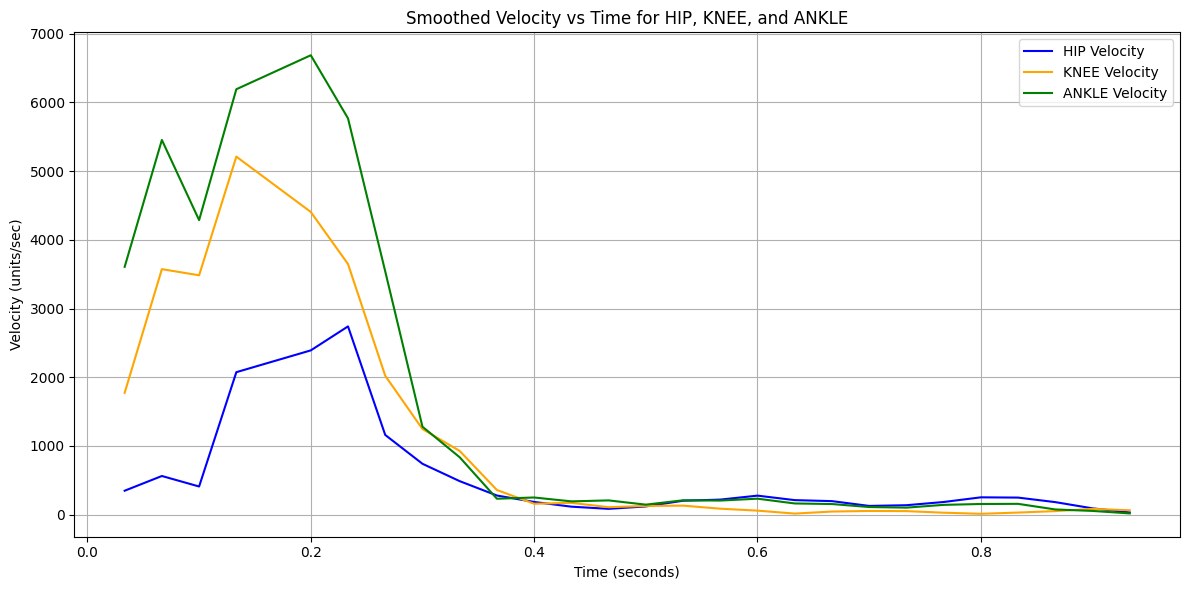

In [5]:
from datetime import datetime
import matplotlib.pyplot as plt

# VELOCITY TIME GRAPH
def parse_timestamp(ts):
    return datetime.strptime(ts, '%Y-%m-%d %H:%M:%S,%f')

# Function to calculate velocities
def calculate_velocities(data):
    velocities = {
        "HIP": [],
        "KNEE": [],
        "ANKLE": [],
    }
    times = {
        "HIP": [],
        "KNEE": [],
        "ANKLE": [],
    }
    # Loop over each keypoint type
    for key in data:
        for i in range(1, len(data[key])):
            t1 = data[key][i-1][0]
            t2 = data[key][i][0]
            delta_t = (t2 - t1)
            displacement = data[key][i][1]
            if delta_t > 0:  # To prevent division by zero
                velocity = displacement / delta_t
                velocities[key].append(velocity)
                times[key].append(t2) # The ending time that is associated with the velocity
    return times, velocities

times, velocities = calculate_velocities(joint_displacement_history)


def smooth(y, box_pts):
    box = np.ones(box_pts) / box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def plot_vt_graph(times, velocities, smoothed=False, box_pts=3, ):
    plt.figure(figsize=(12, 6))
    if smoothed:
        hip_velocities = smooth(velocities['HIP'], box_pts)
        knee_velocities = smooth(velocities['KNEE'], box_pts)
        ankle_velocities = smooth(velocities['ANKLE'], box_pts)
    else:
        hip_velocities = velocities['HIP']
        knee_velocities = velocities['KNEE']
        ankle_velocities = velocities['ANKLE']
    plt.plot(times['HIP'], hip_velocities, label='HIP Velocity', color='blue')
    plt.plot(times['KNEE'], knee_velocities, label='KNEE Velocity', color='orange')
    plt.plot(times['ANKLE'], ankle_velocities, label='ANKLE Velocity', color='green')
    smoothed = "Smoothed" if smoothed else ""
    plt.title(f"{smoothed} Velocity vs Time for HIP, KNEE, and ANKLE")
    plt.xlabel('Time (seconds)')
    plt.ylabel('Velocity (units/sec)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_vt_graph(times, velocities, smoothed=True)


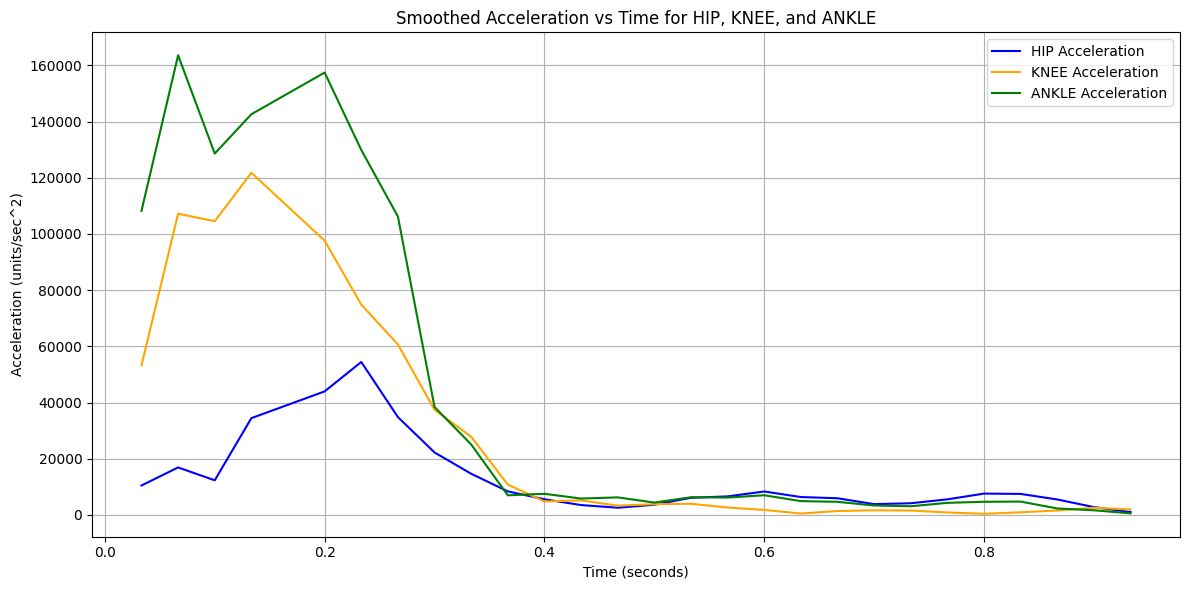

In [6]:
# Acceleration - time graph
def calculate_acceleration(data):
    accelerations = {
        "HIP": [],
        "KNEE": [],
        "ANKLE": [],
    }
    times = {
        "HIP": [],
        "KNEE": [],
        "ANKLE": [],
    }
    # Loop over each keypoint type
    for key in data:
        for i in range(1, len(data[key])):
            t1 = data[key][i-1][0]
            t2 = data[key][i][0]
            delta_t = (t2 - t1)
            displacement = data[key][i][1]
            if delta_t > 0:  # To prevent division by zero
                velocity = displacement / delta_t
                accelerations[key].append(velocity / delta_t)
                times[key].append(t2) # The ending time that is associated with the acceleration
    return times, accelerations

times, accelerations = calculate_acceleration(joint_displacement_history)

def plot_at_graph(times, accelerations, smoothed=False, box_pts=3):
    plt.figure(figsize=(12, 6))
    if smoothed:
        hip_accelerations = smooth(accelerations['HIP'], box_pts)
        knee_accelerations = smooth(accelerations['KNEE'], box_pts)
        ankle_accelerations = smooth(accelerations['ANKLE'], box_pts)
    else:
        hip_accelerations = accelerations['HIP']
        knee_accelerations = accelerations['KNEE']
        ankle_accelerations = accelerations['ANKLE']
    plt.plot(times['HIP'], hip_accelerations, label='HIP Acceleration', color='blue')
    plt.plot(times['KNEE'], knee_accelerations, label='KNEE Acceleration', color='orange')
    plt.plot(times['ANKLE'], ankle_accelerations, label='ANKLE Acceleration', color='green')
    smoothed = "Smoothed" if smoothed else ""
    plt.title(f"{smoothed} Acceleration vs Time for HIP, KNEE, and ANKLE")
    plt.xlabel('Time (seconds)')
    plt.ylabel('Acceleration (units/sec^2)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_at_graph(times, accelerations, smoothed=True)

In [7]:
# 4. Frequency Analysis
# Performing a Fourier Transform to analyze the frequency components of the motion can also help in identifying the smoothness. Smooth motions typically have fewer high-frequency components.

# Example of Frequency Analysis Plot:
from scipy.fft import fft, fftfreq

# Calculate FFT
hip_fft = fft(hip_velocity_history)
frequencies = fftfreq(len(hip_velocity_history), d=frame_time)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(frequencies, np.abs(hip_fft), label='Hip Velocity Frequency Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Frequency Analysis of Hip Motion')
plt.xlim([0, 5])  # Limiting to relevant frequencies
plt.legend()
plt.grid(True)
plt.show()


ModuleNotFoundError: No module named 'scipy'

In [5]:
import numpy as np

def black_mask(video_path, display):
    # Initialize variables for counter logic
    counter = 0
    stage = None
    confirm_frames = 5
    stage_counter = 0
    max_angle_per_rep = 0
    last_angle = 0
    up_stage_threshold_angle = 135
    down_stage_threshold_angle = 105
    elbow_angle_threshold = 50

    # Initialize variables for optical flow
    prev_frame = None
    prev_hip = None
    prev_knee = None
    prev_ankle = None

    # for optical flow postprocessing
    joint_history = {
        "HIP": [],
        "KNEE": [],
        "ANKLE": [],
    }

    joint_displacement_history = {
        "HIP": [],
        "KNEE": [],
        "ANKLE": [],
    }
    joint_velocity_history = {
        "HIP": [],
        "KNEE": [],
        "ANKLE": [],
    }
    timer_started = False
    max_angles = []
    frames_after_start = 0
    frame_rate = None
    elapsed_time = 0
    finished = False
    rep_durations = []  # List to store the duration of each repetition
    rep_start_time = -1  # Uninitialized state
    last_rep_end_time = 0  # To store the end time of the last repetition
    violations = []

    previous_gray = None
    previous_keypoints = None
    keypoints_over_time = []

    try:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise ValueError("Error: Cannot open video file.")
        frame_rate = cap.get(cv2.CAP_PROP_FPS)
    except ValueError as e:
        logging.error(e)
        return
    with mp_pose.Pose(
        min_detection_confidence=0.5, min_tracking_confidence=0.5
    ) as pose:
        while cap.isOpened() and not finished:
            ret, frame = cap.read()
            if not ret:
                logging.warning("No frame captured from the video source.")
                break

            frame_height, frame_width, _ = frame.shape

            # Create a black mask of the same size as the frame
            black_mask = np.zeros_like(frame)

            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False
            results = pose.process(image)
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            current_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)


            if prev_frame is not None and timer_started:
                elapsed_time = get_real_time_from_frames(frames_after_start, frame_rate)
                frames_after_start += 1

            # Process the frame
            if results.pose_landmarks:
                landmarks = results.pose_landmarks.landmark

                # Extract coordinates multiplied by frame dimensions for optical flow and angle calculation
                hip, knee, ankle, shoulder, wrist, elbow = get_landmark_coordinates(
                    landmarks, frame_width, frame_height, side="LEFT"
                )

                keypoints = get_keypoints(landmarks)

                # Draw the landmarks and connections on the black mask
                draw_landmarks_and_connections(black_mask, results)

                # Continue with the rest of the processing logic
                keypoint_array = np.array(
                    [
                        [kp.x * frame.shape[1], kp.y * frame.shape[0]]
                        for kp in keypoints.values()
                    ],
                    dtype=np.float32,
                ).reshape(-1, 1, 2)

                # Calculate motion vectors using optical flow
                if previous_gray is not None and previous_keypoints is not None:
                    p1, st, err = cv2.calcOpticalFlowPyrLK(
                        previous_gray, current_gray, previous_keypoints, None
                    )
                    
                    current_frame_keypoints = {}

                    for i, (new, old) in enumerate(zip(p1, previous_keypoints)):
                        new_x, new_y = new.ravel()
                        old_x, old_y = old.ravel()

                        motion_magnitude = np.sqrt((new_x - old_x) ** 2 + (new_y - old_y) ** 2)
                        motion_angle = np.arctan2(new_y - old_y, new_x - old_x)

                        key = list(keypoints.keys())[i]
                        current_frame_keypoints[key] = (motion_magnitude, motion_angle)
                        logging.info(
                            f"{key} - Magnitude: {motion_magnitude}, Angle: {motion_angle} radians"
                        )

                    keypoints_over_time.append(current_frame_keypoints)
                    previous_keypoints = p1
                else:
                    previous_keypoints = keypoint_array
                
                previous_gray = current_gray

                joint_history["HIP"].append(hip)
                joint_history["KNEE"].append(knee)
                joint_history["ANKLE"].append(ankle)

                # Calculate angles
                angle = calculate_angle(hip, knee, ankle)
                hip_angle = calculate_angle(shoulder, hip, knee)
                display_knee_and_hip_angle(black_mask, angle, knee, hip_angle, hip)

                if (
                    prev_hip is not None
                    and prev_knee is not None
                    and prev_ankle is not None
                ):
                    # Calculate displacements
                    joint_displacement_history = calculate_and_draw_joint_displacement(
                        prev_frame,
                        [prev_hip, prev_knee, prev_ankle],
                        [hip, knee, ankle],
                        black_mask,
                        joint_displacement_history,
                        elapsed_time,
                    )

                    # Get most recent displacement from history
                    hip_displacement = joint_displacement_history["HIP"][-1][1]
                    knee_displacement = joint_displacement_history["KNEE"][-1][1]
                    ankle_displacement = joint_displacement_history["ANKLE"][-1][1]

                    # Determine if the action timer should start
                    if not timer_started and should_start_timer(
                        hip_angle,
                        hip_displacement,
                        knee_displacement,
                        ankle_displacement,
                    ):
                        timer_started = True
                        logging.info(f"Timer started at {elapsed_time:.2f} seconds.")

                prev_frame = frame.copy()
                prev_hip, prev_knee, prev_ankle = hip, knee, ankle

                # Counting logic
                if stage is None:
                    stage = "up" if angle > up_stage_threshold_angle else "down"

                if (
                    timer_started
                    and stage == "down"
                    and angle < up_stage_threshold_angle
                ):
                    if rep_start_time == -1:
                        rep_start_time = (
                            elapsed_time  # Only set once per rep to avoid resetting
                        )

                # Transition from DOWN to UP
                if stage == "down" and angle > up_stage_threshold_angle:
                    stage_counter += 1
                    if stage_counter >= confirm_frames:
                        stage = "up"
                        stage_counter = 0
                        counter += 1
                        logging.info(f"Transitioned to up. Total reps: {counter}")
                        max_angles.append(max_angle_per_rep)
                        max_angle_per_rep = 0  # Reset max angle for the new repetition
                        rep_duration = elapsed_time - last_rep_end_time
                        rep_durations.append(
                            rep_duration
                        )  # Store the duration of the rep
                        last_rep_end_time = (
                            elapsed_time  # Set end time for the next rep
                        )
                        logging.info(
                            f"Repetition {counter} completed in {rep_duration:.2f} seconds."
                        )

                # Transition from UP to DOWN
                elif stage == "up" and angle < down_stage_threshold_angle:
                    stage_counter += 1
                    if stage_counter >= confirm_frames:
                        stage = "down"
                        stage_counter = 0
                        logging.info("Transitioned to down.")

                # Check if 5 reps are completed
                if check_completion(counter, stage):
                    logging.info(
                        f"5 repetitions completed in {elapsed_time:.2f} seconds."
                    )
                    finished = True

                # Update max angle
                if angle > max_angle_per_rep:
                    max_angle_per_rep = angle
                last_angle = angle

                if display:
                    display_information(black_mask, counter, stage, max_angle_per_rep)
                    display_timer(black_mask, elapsed_time)
                    cv2.imshow("5 Rep Sit Stand Test", black_mask)

                if cv2.waitKey(10) & 0xFF == ord("q"):
                    break

        cap.release()
        cv2.destroyAllWindows()
        summarise_results(counter, elapsed_time, rep_durations, violations, max_angles)

        return (
            "5 Sit Stand",
            determine_failure(elapsed_time, counter, False),
            counter,
            elapsed_time,
            rep_durations,
            violations,
            max_angles,
            keypoint_mean_magnitudes,
            keypoint_std_devs,
            keypoint_circular_mean,
            keypoint_circular_std,
        )

black_mask(video_path, True)

2024-09-26 01:13:37,784 - INFO - NOSE - Magnitude: 6.801382110650426, Angle: -0.16126419603824615 radians
2024-09-26 01:13:37,785 - INFO - LEFT_SHOULDER - Magnitude: 8.979321776365628, Angle: -0.27051642537117004 radians
2024-09-26 01:13:37,786 - INFO - RIGHT_SHOULDER - Magnitude: 3.165732488144172, Angle: 0.033071137964725494 radians
2024-09-26 01:13:37,787 - INFO - LEFT_HIP - Magnitude: 0.5434159145927208, Angle: -0.19417956471443176 radians
2024-09-26 01:13:37,788 - INFO - RIGHT_HIP - Magnitude: 1.008444900003831, Angle: -0.3384599983692169 radians
2024-09-26 01:13:37,789 - INFO - LEFT_KNEE - Magnitude: 1.755157640501684, Angle: -1.7306225299835205 radians
2024-09-26 01:13:37,790 - INFO - RIGHT_KNEE - Magnitude: 1.8065783515713796, Angle: -2.6906371116638184 radians
2024-09-26 01:13:37,791 - INFO - LEFT_ANKLE - Magnitude: 1.7290755620380653, Angle: -0.5092859268188477 radians
2024-09-26 01:13:37,792 - INFO - RIGHT_ANKLE - Magnitude: 0.3423100474690082, Angle: -0.7630171179771423 rad

('5 Sit Stand',
 'PASSED',
 1,
 0.8008000000000001,
 [0.5005000000000001],
 [],
 [152.96294731421364],
 {'NOSE': 2.2848180321487206,
  'LEFT_SHOULDER': 1.639040051757955,
  'RIGHT_SHOULDER': 5.565648081013061,
  'LEFT_HIP': 0.26271483914946336,
  'RIGHT_HIP': 0.4969836698812767,
  'LEFT_KNEE': 2.6966151476573805,
  'RIGHT_KNEE': 3.1422280012354067,
  'LEFT_ANKLE': 3.3055913533696435,
  'RIGHT_ANKLE': 1.836242319489615,
  'LEFT_TOE': 5.8815465297802225,
  'RIGHT_TOE': 2.287916075769749},
 {'NOSE': 1.89852852595827,
  'LEFT_SHOULDER': 2.0303590861714653,
  'RIGHT_SHOULDER': 5.082678480092912,
  'LEFT_HIP': 0.20776765675183068,
  'RIGHT_HIP': 0.47635338920341513,
  'LEFT_KNEE': 1.611888388080753,
  'RIGHT_KNEE': 3.050549064752594,
  'LEFT_ANKLE': 3.691694623633552,
  'RIGHT_ANKLE': 3.244837984823865,
  'LEFT_TOE': 3.6007956282723392,
  'RIGHT_TOE': 2.2058180880565854},
 {'NOSE': 0.09165393223920049,
  'LEFT_SHOULDER': -1.6762327825825833,
  'RIGHT_SHOULDER': -0.03620967932544383,
  'LEFT_

: 

In [15]:
# test, status, reps, time, rep_durations, violations, max_angles, keypoint_mean_magnitudes, keypoint_std_devs, keypoint_circular_mean, keypoint_circular_std
import numpy as np
print(time)
print(np.mean(rep_durations))
print(max_angles)

# filter out only knees, hips only
keypoints = ["LEFT_ANKLE","LEFT_KNEE", "LEFT_HIP"]
# filter out only the relevant keypoints
keypoints_movement_variation = {key: keypoint_std_devs[key] for key in keypoints}
print(keypoints_movement_variation)

15.382033333333334
2.7293933333333333
[152.96294731421364, 168.75765725354563, 172.24433597637974, 179.8568132052195, 177.06945514429577]
{'LEFT_ANKLE': 1.3953261998539097, 'LEFT_KNEE': 4.626530515945847, 'LEFT_HIP': 14.424931093268656}


  Frailty Level  Elapsed Time (s)  Average Time per Rise (s)  \
0           Low             7.865                      1.573   
1      Moderate            11.428                      2.286   
2          High            15.768                      3.154   

                 Max Angles Reached per Rep  Movement Variation (LEFT_ANKLE)  \
0  [152.96, 168.76, 172.24, 179.86, 177.07]                             1.40   
1  [145.35, 160.12, 165.89, 170.45, 168.74]                             0.95   
2  [140.15, 152.33, 156.76, 160.45, 158.21]                             0.72   

   Movement Variation (LEFT_KNEE)  Movement Variation (LEFT_HIP)  
0                            4.63                          14.42  
1                            3.21                          10.55  
2                            2.58                           7.39  


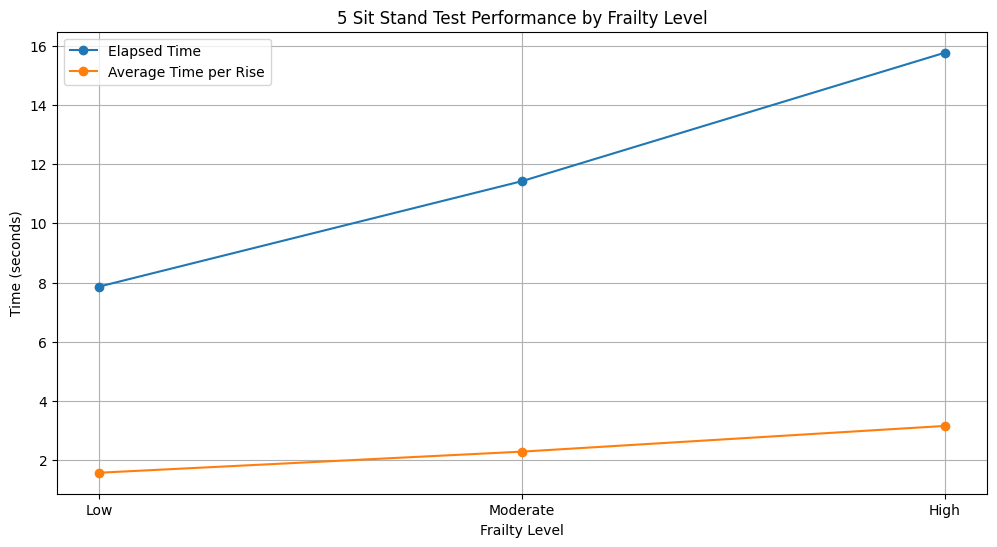

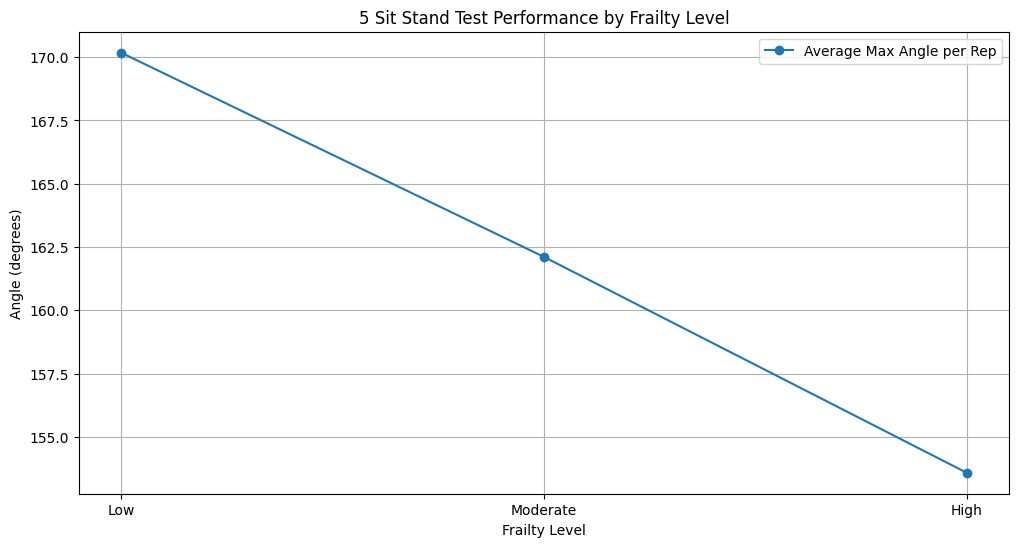

In [24]:
data = {
    'Frailty Level': ['Low', 'Moderate', 'High'],
    'Elapsed Time (s)': [7.865, 11.428, 15.768],
    'Average Time per Rise (s)': [1.573, 2.286, 3.154],
    'Max Angles Reached per Rep': [
        [152.96, 168.76, 172.24, 179.86, 177.07],
        [145.35, 160.12, 165.89, 170.45, 168.74],
        [140.15, 152.33, 156.76, 160.45, 158.21]
    ],
    'Movement Variation (LEFT_ANKLE)': [1.40, 0.95, 0.72],
    'Movement Variation (LEFT_KNEE)': [4.63, 3.21, 2.58],
    'Movement Variation (LEFT_HIP)': [14.42, 10.55, 7.39]
}

# Create DataFrame
df_frailty = pd.DataFrame(data)
print(df_frailty)

# plot the data
plt.figure(figsize=(12, 6))
plt.plot(df_frailty['Frailty Level'], df_frailty['Elapsed Time (s)'], marker='o', label='Elapsed Time')
plt.plot(df_frailty['Frailty Level'], df_frailty['Average Time per Rise (s)'], marker='o', label='Average Time per Rise')
# plot the average max angles
plt.title('5 Sit Stand Test Performance by Frailty Level')
plt.xlabel('Frailty Level')
plt.ylabel('Time (seconds)')
plt.legend()
plt.grid(True)
plt.show()


# make a plot for the average max angles
plt.figure(figsize=(12, 6))
max_angles = np.array(df_frailty['Max Angles Reached per Rep'].tolist())
mean_max_angles = np.mean(max_angles, axis=1)
plt.plot(df_frailty['Frailty Level'], mean_max_angles, marker='o', label='Average Max Angle per Rep')
plt.title('5 Sit Stand Test Performance by Frailty Level')
plt.xlabel('Frailty Level')
plt.ylabel('Angle (degrees)')
plt.legend()
plt.grid(True)
plt.show()


     Keyjoint    Low  Moderate  High
0  LEFT_ANKLE   1.40      0.95  0.72
1   LEFT_KNEE   4.63      3.21  2.58
2    LEFT_HIP  14.42     10.55  7.39


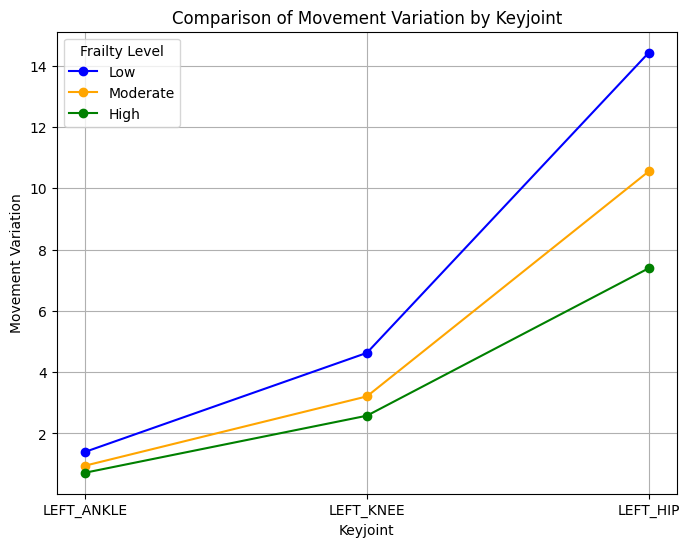

In [28]:
# Creating the plot with keypoints on the x-axis
keypoints = ["LEFT_ANKLE", "LEFT_KNEE", "LEFT_HIP"]

# Movement variation values for Low, Moderate, High frailty levels
low_variation = [1.40, 4.63, 14.42]
moderate_variation = [0.95, 3.21, 10.55]
high_variation = [0.72, 2.58, 7.39]

# make a dataframe
df_keypoints = pd.DataFrame({
    'Keyjoint': keypoints,
    'Low': low_variation,
    'Moderate': moderate_variation,
    'High': high_variation
})
print(df_keypoints)


# Creating the plot
plt.figure(figsize=(8, 6))
plt.plot(keypoints, low_variation, marker='o', label='Low', color='blue')
plt.plot(keypoints, moderate_variation, marker='o', label='Moderate', color='orange')
plt.plot(keypoints, high_variation, marker='o', label='High', color='green')

# Titles and labels
plt.title("Comparison of Movement Variation by Keyjoint")
plt.xlabel("Keyjoint")
plt.ylabel("Movement Variation")

# Grid and Legend
plt.grid(True)
plt.legend(title='Frailty Level')

# Show the plot
plt.show()


In [8]:
video_path = "/Users/brennanlee/Desktop/opencv-healthcare/test/High_Frailty/5ST_High.mp4"
(
    test,
    high_status,
    high_reps,
    high_time,
    high_rep_durations,
    high_violations,
    high_max_angles,
    high_keypoint_mean_magnitudes,
    high_keypoint_std_devs,
    high_keypoint_circular_mean,
    high_keypoint_circular_std,
) = process_sit_stand(video_path, True)
print(high_status)
print(high_time)
print(high_max_angles)
print(high_keypoint_std_devs)



2024-10-02 17:31:41,600 - INFO - NOSE - Magnitude: 1.5973998452190517, Angle: -0.057861704379320145 radians
2024-10-02 17:31:41,601 - INFO - LEFT_SHOULDER - Magnitude: 1.8725878955682134, Angle: 0.11803607642650604 radians
2024-10-02 17:31:41,601 - INFO - RIGHT_SHOULDER - Magnitude: 1.5314411474637584, Angle: 0.03356397524476051 radians
2024-10-02 17:31:41,601 - INFO - LEFT_HIP - Magnitude: 1.5971956696727738, Angle: 0.39144885540008545 radians
2024-10-02 17:31:41,602 - INFO - RIGHT_HIP - Magnitude: 0.9817705232415692, Angle: 0.20052896440029144 radians
2024-10-02 17:31:41,603 - INFO - LEFT_KNEE - Magnitude: 0.9475338349679956, Angle: 0.44924354553222656 radians
2024-10-02 17:31:41,604 - INFO - RIGHT_KNEE - Magnitude: 0.6363453764945026, Angle: 0.38235872983932495 radians
2024-10-02 17:31:41,604 - INFO - LEFT_ANKLE - Magnitude: 1.3349374885564662, Angle: 0.6447035670280457 radians
2024-10-02 17:31:41,605 - INFO - RIGHT_ANKLE - Magnitude: 0.848343210992007, Angle: 0.4702596962451935 rad

FAILED
16.066666666666666
[161.24823365609728, 177.17059207107283, 177.99238939484388, 179.92446744366828, 175.4901613695013]
{'NOSE': 7.489442116366047, 'LEFT_SHOULDER': 9.59735050449439, 'RIGHT_SHOULDER': 8.887411279416208, 'LEFT_HIP': 25.967288813547594, 'RIGHT_HIP': 24.73376514725966, 'LEFT_KNEE': 6.15667585787634, 'RIGHT_KNEE': 3.2064419171994025, 'LEFT_ANKLE': 1.8285152675939047, 'RIGHT_ANKLE': 1.710272174431923, 'LEFT_TOE': 2.1519994334253036, 'RIGHT_TOE': 1.5376858503979836}
